In [1]:
### Notebook for P3D stuff!
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import jax
jax.config.update('jax_platform_name', 'gpu')
from jax.lib import xla_bridge
print("jax version",jax.__version__)
print(xla_bridge.get_backend().platform)

import numpy as np
import jax.numpy as jnp 

%pylab inline

jax version 0.4.26
gpu
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
!nvidia-smi


Thu Mar 27 14:41:09 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti      Off| 00000000:1A:00.0 Off |                  N/A |
| 16%   27C    P8                1W / 250W|     18MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

/home/guoqi/.conda/envs/MAPLE/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


|   3  Tesla V100-PCIE-32GB            Off| 00000000:20:00.0 Off |                    0 |
| N/A   42C    P0               40W / 250W|    312MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
|   4  Tesla V100-PCIE-32GB            Off| 00000000:21:00.0 Off |                    0 |
| N/A   36C    P0               26W / 250W|      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
|   5  Tesla V100-PCIE-32GB            Off| 00000000:22:00.0 Off |                    0 |
| N/A   42C    P0               37W / 250W|  24980MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+---------

In [3]:
#from jaxpm.kernels import *
#uses jaxpm for some kernels... maybe?

In [4]:
#First things... set the redshift

z= 2.0

#set box geometry, probably should wrap this into the fiducial model file (hdf5?) to lead to less fiddling bugs

bs =  50#box size in Mpc/h
nc =  150#number of pixels per side

mesh_shape = [nc,nc,nc]
box_size = [bs,bs,bs]

ptcl_grid_shape = (nc,) * 3
ptcl_spacing = bs/nc



In [5]:
#some fourier space routines
from helper_functions import *

kvec = rfftnfreq_2d(ptcl_grid_shape, ptcl_spacing)
k = jnp.sqrt(sum(k**2 for k in kvec))
#this vector is needed for lots of fourier space transformation operations later on...
print(k.shape)

/tmp/ipykernel_17364/2721841557.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  k = jnp.sqrt(sum(k**2 for k in kvec))
2025-03-27 14:41:11.789089: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.8.93). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(150, 150, 76)


In [6]:
#in this setup, LOS (z) is along the 0 axis, be careful when loading in data!

kz = jnp.ones(k.shape)*kvec[0]**2

kx = jnp.ones(k.shape)*(kvec[1]**2+kvec[2]**2)
#tiny deltas are added to avoid div by zero errors
kk = (kx+kz)+10**(-8)
kmu = jnp.sqrt((kz/(k**2+0.00001)))


In [7]:
np.max(k)


Array(16.324194, dtype=float32)

In [8]:
#m_array[:,0][:50].max()
from jax import jit, checkpoint, custom_vjp
from jax.scipy.ndimage import map_coordinates

#loading in fiducial model
m_array = np.load("pkell_red.npy")
m_array = jnp.array(m_array[np.where(m_array[:,1]<=4)])
kmax = m_array[-1,0]
print(m_array.shape,kmax)


(120, 3) 15.802141


In [9]:
import jaxinterp2d

k_in = (k.flatten()/kmax*39-0.6)

l0 = np.where(m_array[:,1]==0)[0]
k_l0 = m_array[l0,0]
Pk_l0 = m_array[l0,2]
func1 = map_coordinates(Pk_l0,np.array([k_in]),mode="nearest",order=1)
func1 = func1.reshape(k.shape[0],k.shape[1],k.shape[2])

l2 = np.where(m_array[:,1]==2)[0]
k_l2 = m_array[l2,0]
Pk_l2 = m_array[l2,2]
func2 = map_coordinates(Pk_l2,np.array([k_in]),mode="nearest",order=1)
func2 = func2.reshape(k.shape[0],k.shape[1],k.shape[2])

l4 = np.where(m_array[:,1]==4)[0]
k_l4 = m_array[l4,0]
Pk_l4 = m_array[l4,2]
func4 = map_coordinates(Pk_l4,np.array([k_in]),mode="nearest",order=1)
func4 = func4.reshape(k.shape[0],k.shape[1],k.shape[2])

# l6 = np.where(m_array[:,1]==6)[0]
# k_l6 = m_array[l6,0]
# Pk_l6 = m_array[l6,2]
# func6 = map_coordinates(Pk_l6,np.array([k_in]),mode="nearest",order=1)
# func6 = func6.reshape(k.shape[0],k.shape[1],k.shape[2])

# l8 = np.where(m_array[:,1]==8)[0]
# k_l8 = m_array[l8,0]
# Pk_l8 = m_array[l8,2]
# func8 = map_coordinates(Pk_l8,np.array([k_in]),mode="nearest",order=1)
# func8 = func8.reshape(k.shape[0],k.shape[1],k.shape[2])


In [10]:
k_l0

Array([ 0.31081638,  0.6399725 ,  1.0293201 ,  1.4254256 ,  1.8161561 ,
        2.2098646 ,  2.6080446 ,  3.0070932 ,  3.4059618 ,  3.8061743 ,
        4.207292  ,  4.6073422 ,  5.005641  ,  5.403759  ,  5.803395  ,
        6.202688  ,  6.6025615 ,  7.003379  ,  7.4038296 ,  7.803882  ,
        8.203085  ,  8.602703  ,  9.002726  ,  9.402837  ,  9.802631  ,
       10.20262   , 10.602747  , 11.002615  , 11.4020195 , 11.802091  ,
       12.202493  , 12.602277  , 13.002484  , 13.40161   , 13.801209  ,
       14.202413  , 14.6025715 , 15.002472  , 15.402182  , 15.802141  ],      dtype=float32)

In [11]:
from scipy.special import legendre

# np.min(func1*legendre(0)(kmu)+func2*legendre(2)(kmu)+func4*legendre(4)(kmu)+func6*legendre(6)(kmu)+func8*legendre(8)(kmu))

In [12]:
k_ind_optim_max = 13
ell_bins=3
k_bins=40
tff = m_array[:,2].reshape(ell_bins,k_bins)
# theta_fid = m_array[:,2].reshape(ell_bins,k_bins)[:,:k_ind_optim_max]
theta_fid = m_array[:k_bins,2].reshape(1,k_bins)[:,:k_ind_optim_max]

from scipy.special import legendre

def power_b(theta,tff=tff):    
    # tff = tff.at[:,:k_ind_optim_max].set(theta.reshape(ell_bins,k_ind_optim_max))
    tff = tff.at[0,:k_ind_optim_max].set(theta.reshape(1,k_ind_optim_max).ravel())
    func1 = map_coordinates(tff[0], np.array([k_in]), mode="nearest", order=1)
    func1 = func1.reshape(k.shape[0],k.shape[1],k.shape[2])
    func2 = map_coordinates(tff[1], np.array([k_in]), mode="nearest", order=1)
    func2 = func2.reshape(k.shape[0],k.shape[1],k.shape[2])
    func4 = map_coordinates(tff[2], np.array([k_in]), mode="nearest", order=1)
    func4 = func4.reshape(k.shape[0],k.shape[1],k.shape[2])
    # func6 = map_coordinates(tff[3], np.array([k_in]), mode="nearest", order=1)
    # func6 = func6.reshape(k.shape[0],k.shape[1],k.shape[2])
    # func8 = map_coordinates(tff[4], np.array([k_in]), mode="nearest", order=1)
    # func8 = func8.reshape(k.shape[0],k.shape[1],k.shape[2])
    # func = jax.nn.relu(func1*legendre(0)(kmu)+func2*legendre(2)(kmu)+func4*legendre(4)(kmu)+func6*legendre(6)(kmu)+func8*legendre(8)(kmu))
    func = jax.nn.relu(func1*legendre(0)(kmu)+func2*legendre(2)(kmu)+func4*legendre(4)(kmu))
    return func*25


In [13]:
#muse componenet...
from functools import partial
import jax
import jax.numpy as jnp
from muse_inference.jax import JaxMuseProblem

In [14]:

#file name
prefix = "V1_DENSE_"
loc = "./configs/"

naa = np.load(loc+prefix+"naa.npy")
kernel = np.load(loc+prefix+"kernel.npy")
skewers_skn = np.load(loc+prefix+"skewers_skn.npy")
skewers_dla = np.load(loc+prefix+"skewers_dla.npy")
skewers_fin = np.load(loc+prefix+"skewers_fin.npy")



@jit
def cic_readout_jit_jnc(mesh,naa,kernel,bs=False):
    #"highly optimized" CIC, need to preprocess lots of things... don't diff output coords
    meshvals = mesh.flatten()[naa].reshape(-1,8).T#mesh[tuple(neighboor_coords[0,:,:].T.tolist())]
    weightedvals = meshvals.T* kernel[0]
    values = np.sum(weightedvals, axis=-1)
    
    return values



In [15]:
tf_cut_flat = theta_fid.flatten()

noise_level = 1.0

def gen_map_lya(theta,z):
    modes = z[:nc**3].reshape((nc,nc,nc))    
    Plin = power_b(theta)
    conv_field = jnp.fft.rfftn(modes).conj()*Plin**(1/2)
    lin_modes_real = jnp.fft.irfftn(conv_field).T[:,:,:]

    lya_values = cic_readout_jit_jnc(lin_modes_real,naa,kernel)
    return lya_values
                 
class Jax3DMuseProblem_flat(JaxMuseProblem):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    #@jax.jit
    def sample_x_z(self, key, θ):
        keys = jax.random.split(key, 2)
        z = jax.random.normal(keys[0], (nc*nc*nc,))
        
        x = gen_map_lya(θ,z) + (0.05*skewers_skn)*jax.random.normal(keys[1], (kernel.shape[1],)) #1*jax.random.normal(keys[1], (32**3,)).reshape((32,32,32))
   #     print(z.shape,x.shape)
        return (x, z)

  #  @jax.jit
    def logLike(self, x, z, θ):
        return -(jnp.sum((x - gen_map_lya(θ,z))**2/((0.05*skewers_skn)**2))+ jnp.sum(z**2.0))

  #  @jax.jit
    def logPrior(self, θ):
        return -jnp.sum(((θ-jnp.array(tf_cut_flat)*1.1)**2 / (2*(tf_cut_flat*0.4)**2)))
    


In [16]:
prob = Jax3DMuseProblem_flat(implicit_diff=True,jit=False)
key = jax.random.PRNGKey(100)
(x, z) = prob.sample_x_z(key, tf_cut_flat)
prob.set_x(x)

In [17]:
modes = z[:nc**3].reshape((nc,nc,nc))    
Plin = power_b(tf_cut_flat)
conv_field = jnp.fft.rfftn(modes).conj()*Plin**(1/2)
lin_modes_real = jnp.fft.irfftn(conv_field).T[:,:,:]

np.save("example_gen_field",lin_modes_real)

In [18]:
rng = jax.random.PRNGKey(1)

In [19]:
x_data = x

In [20]:
from numpy.random import SeedSequence, default_rng
from copy import copy

start_point = jnp.array(tf_cut_flat)*1.2#+np.random.randn(len(tf_cut_flat))*jnp.array(tf_cut_flat)*0.01)

def _split_rng(rng, N):
    keyz = []
    for i in range(N):
        rng, subkey = jax.random.split(rng)
        keyz.append(rng)
    return keyz
    
θ = start_point

maxsteps = 100
nsims= 10
rng = jax.random.PRNGKey(1)

xz_sims = [prob.sample_x_z(_rng, θ) for _rng in _split_rng(rng, nsims)]
xs = [x_data] + [x for (x,_) in xz_sims]
ẑs = [z*0]     + [z*0 for (x, z) in xz_sims]

In [21]:
print(x_data)

[-0.04762251  0.00198166 -0.13119623 ...  0.09571266  0.06686439
 -0.07161489]


In [22]:
from jax import grad, hessian, jacfwd, jvp, value_and_grad, vmap

def gradθ_hessθ_logPrior(θ, transformed_θ=None):
        g = grad(prob.logPrior)(θ)
        H = hessian(lambda θ_vec: prob.logPrior(unravel_θ(θ_vec)))(ravel_θ(θ))
        return (g, H)

step: 1 0.7
[[-2.1691897e-10  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00 -2.1863206e-10  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.2131941e-09  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -4.7430605e-11
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -1.1857177e-11  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  

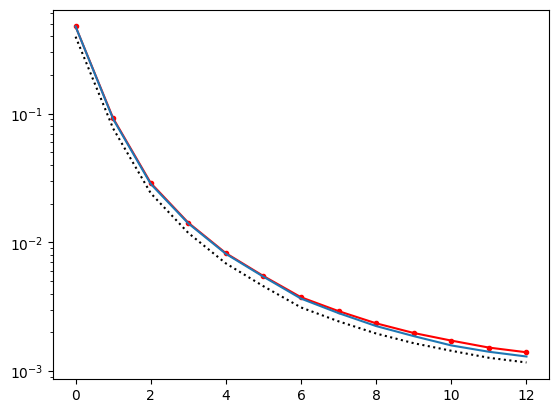

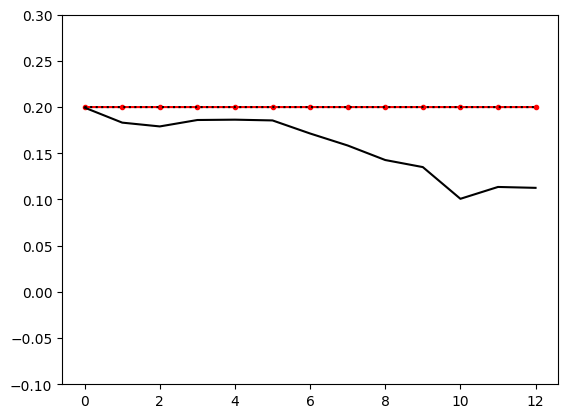

step: 4 0.6649999999999999
[[-6.8229839e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00 -2.0164953e-05  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.1694441e-06  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -4.3990426e-07
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -1.3888999e-07  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  

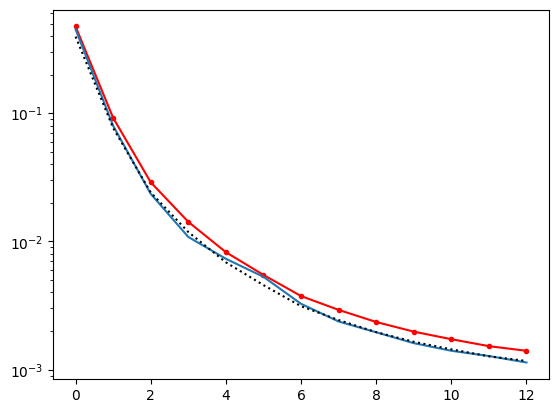

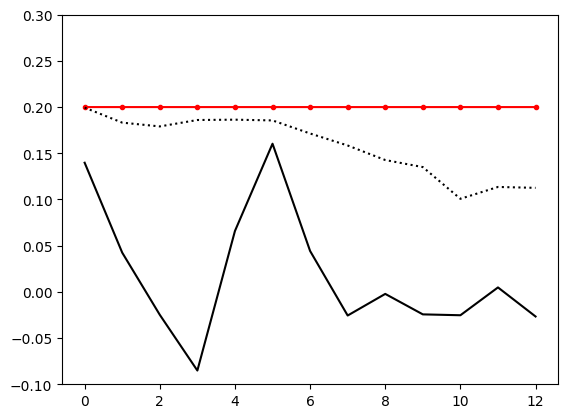

step: 7 0.6317499999999999
[[-5.51023695e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -4.46450940e-05  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.05877200e-06  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.39971268e-07
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.49491393e-07  0.00000000e+00  0.00

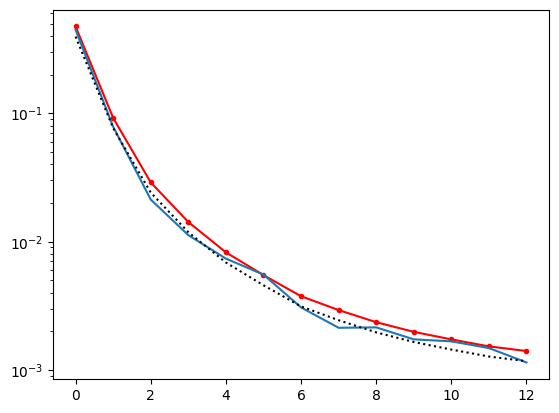

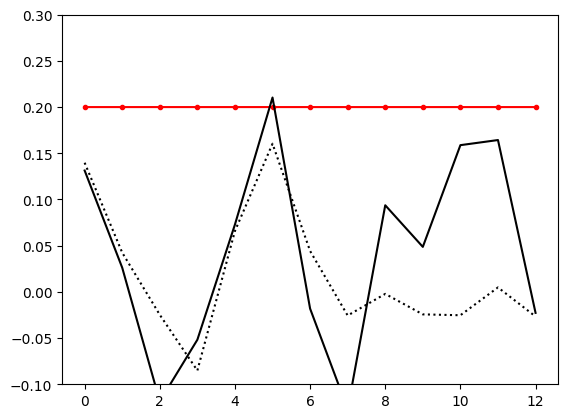

step: 10 0.6001624999999999
[[-5.6064676e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00 -3.8406451e-05  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.3728850e-06  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.4834652e-06
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -2.9715815e-07  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00 

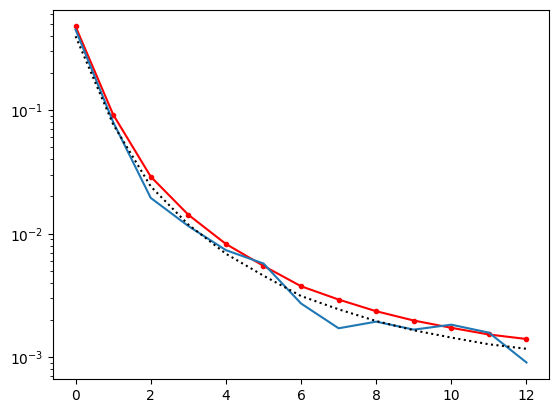

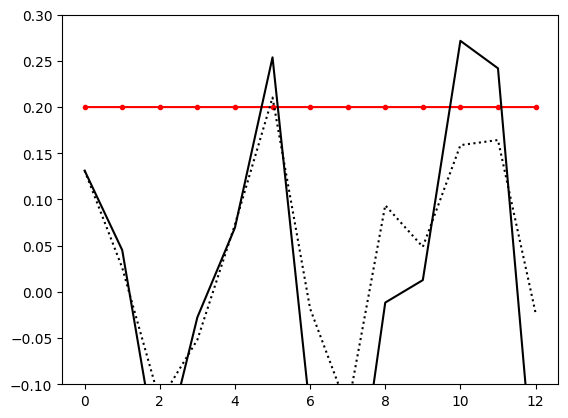

step: 13 0.5701543749999999
[[-5.1829079e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00 -3.9829942e-05  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.4172854e-06  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.2969432e-06
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -2.6755043e-07  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00 

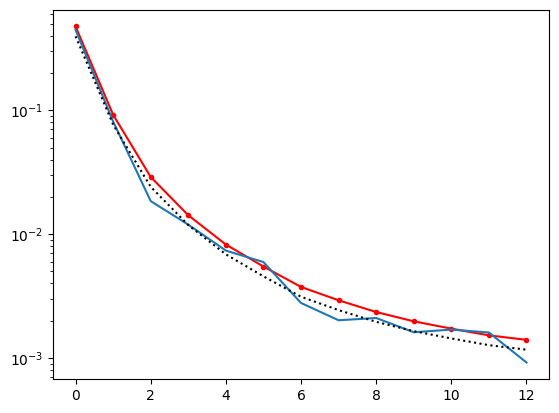

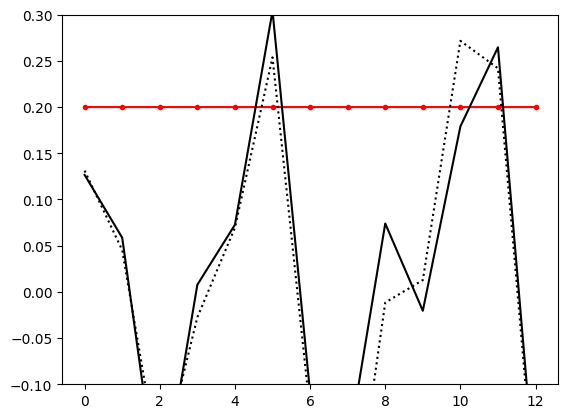

step: 16 0.5416466562499999
[[-6.0731085e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00 -3.9670220e-05  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.3965571e-06  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.3129657e-06
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -2.7124412e-07  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00 

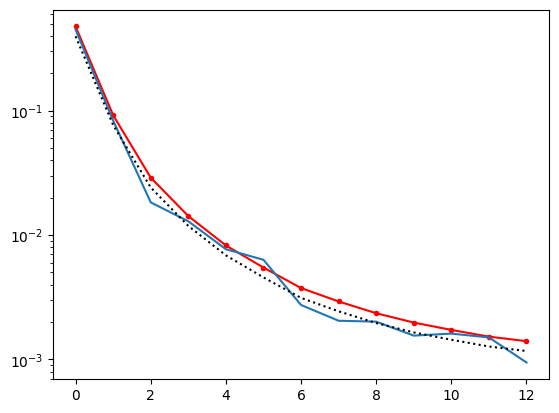

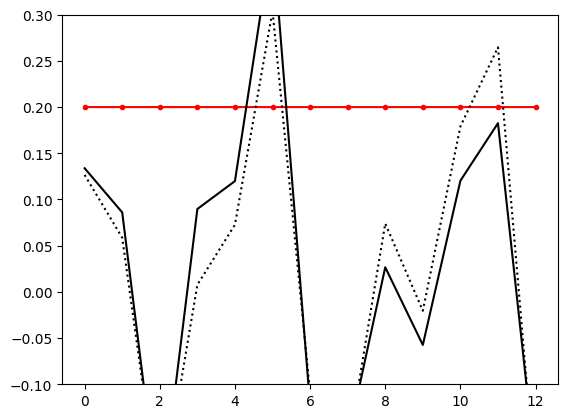

step: 19 0.5145643234374998
[[-5.8891298e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00 -4.2355237e-05  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.5156363e-06  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.4102416e-06
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -2.9029974e-07  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00 

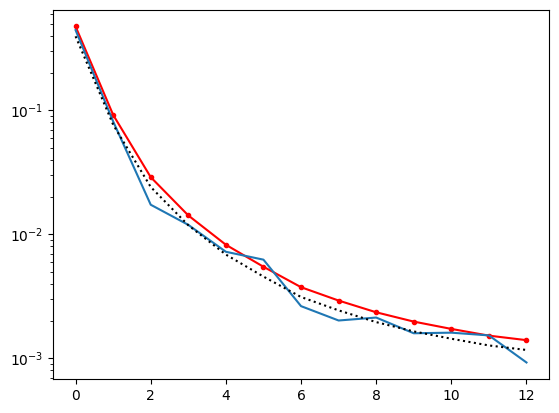

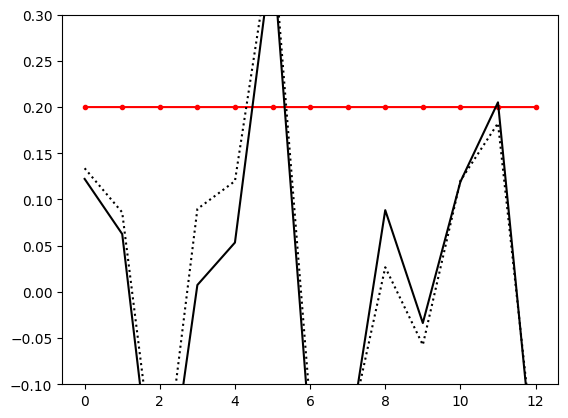

step: 22 0.48883610726562476
[[-5.9226336e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00 -3.8817696e-05  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.4147570e-06  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.2996222e-06
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -2.7250996e-07  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00

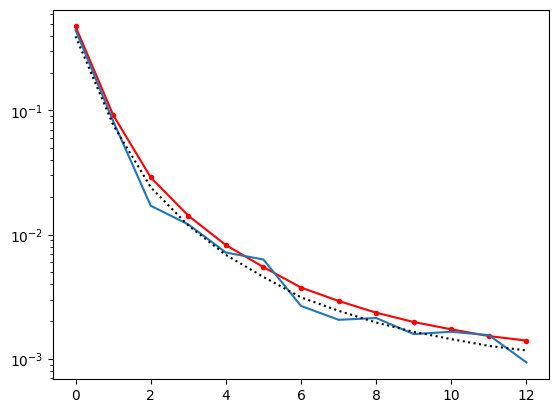

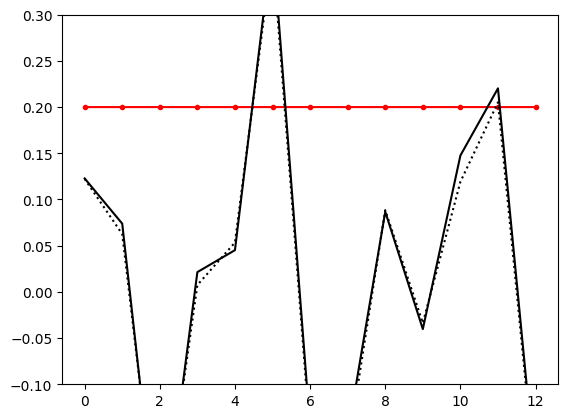

step: 25 0.4643943019023435
[[-5.7293708e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00 -4.0729639e-05  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.3879302e-06  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.2695320e-06
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -2.7134465e-07  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00 

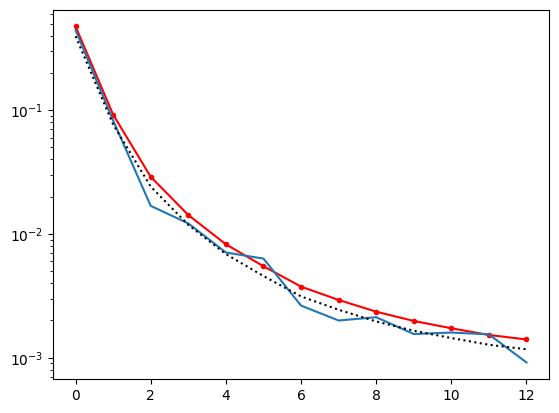

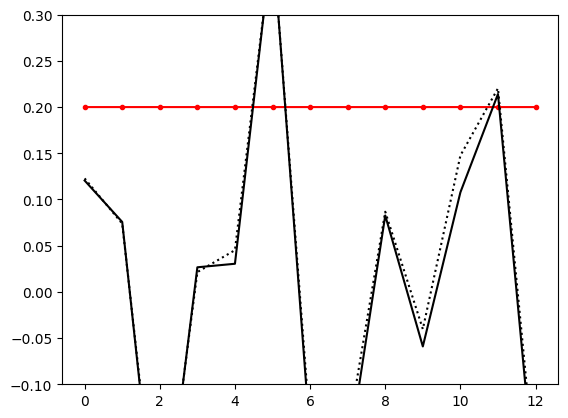

step: 28 0.44117458680722627
[[-5.51954901e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -3.92727125e-05  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.38448866e-06  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.28449108e-06
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.75644908e-07  0.00000000e+00  0.

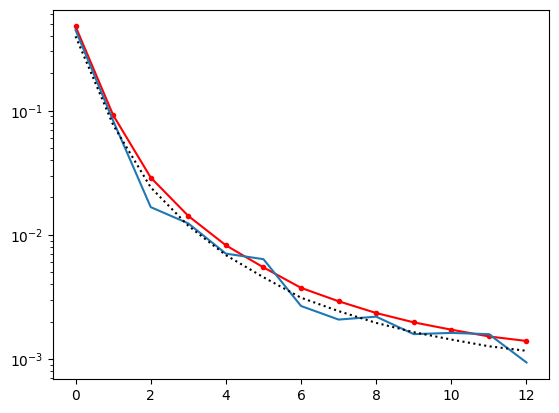

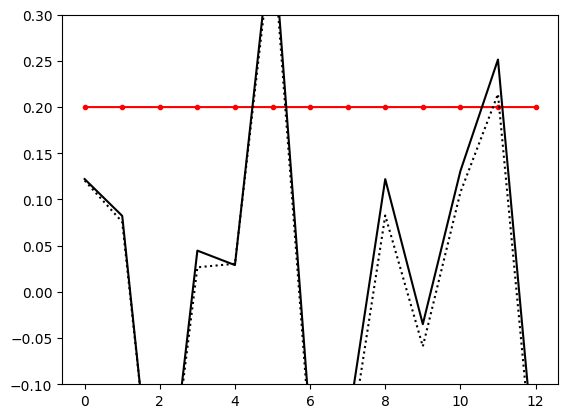

step: 31 0.4191158574668649
[[-1.86679099e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -1.40903867e-05  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.88377418e-08  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.31478289e-09
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -5.53979862e-10  0.00000000e+00  0.0

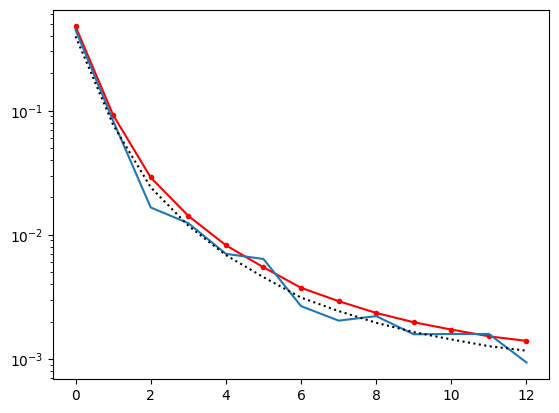

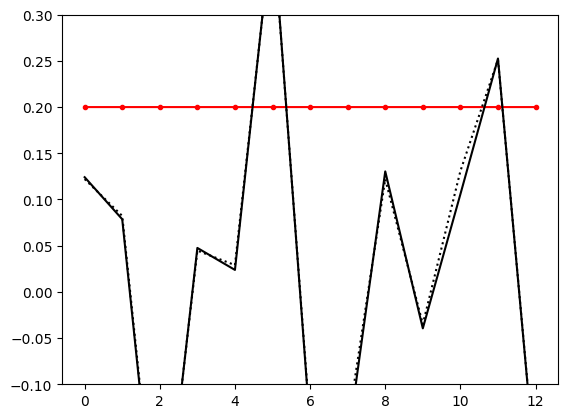

step: 34 0.39816006459352166
[[-5.86596143e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -4.04211351e-05  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.39007579e-06  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.27119881e-06
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.77873028e-07  0.00000000e+00  0.

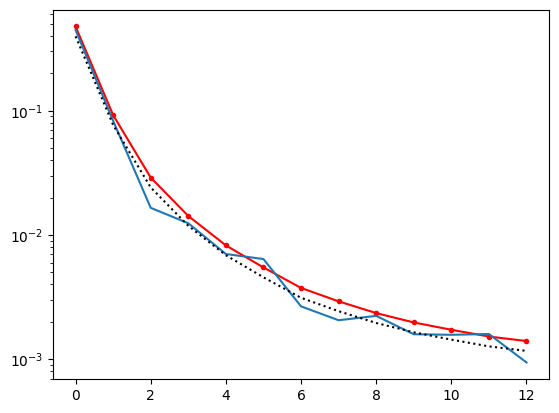

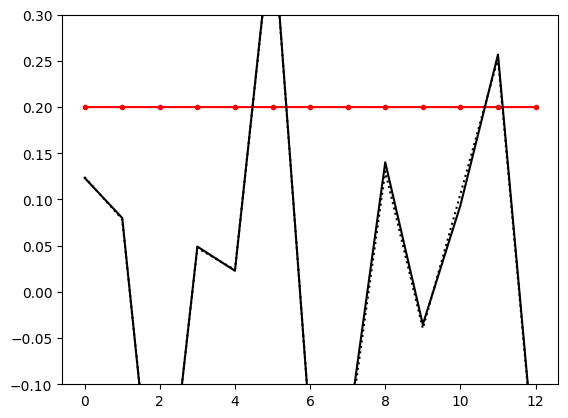

step: 37 0.37825206136384554
[[-5.7213817e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00 -3.7356884e-05  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.3180022e-06  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.2820394e-06
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -2.6737038e-07  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00

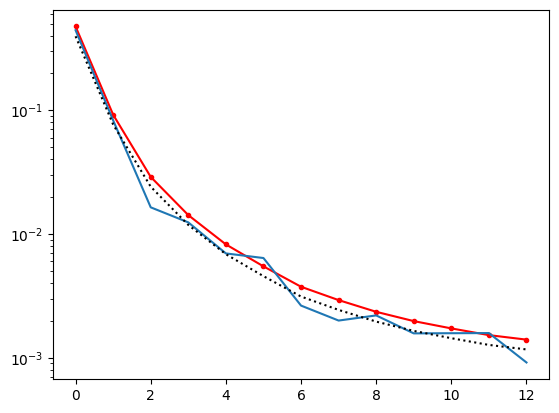

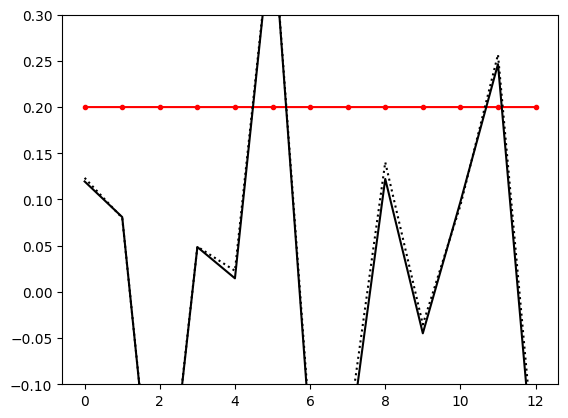

step: 40 0.3593394582956532
[[-5.66658680e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -4.05329884e-05  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.37419761e-06  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.25634165e-06
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.67082413e-07  0.00000000e+00  0.0

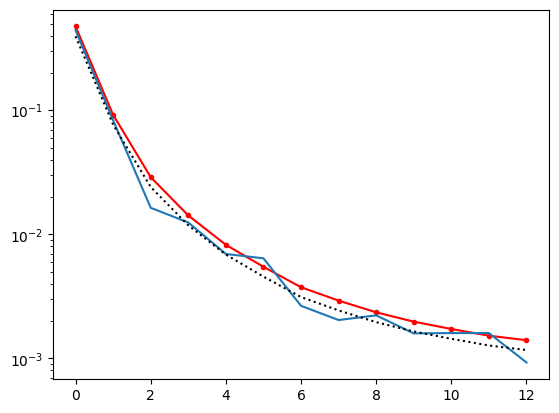

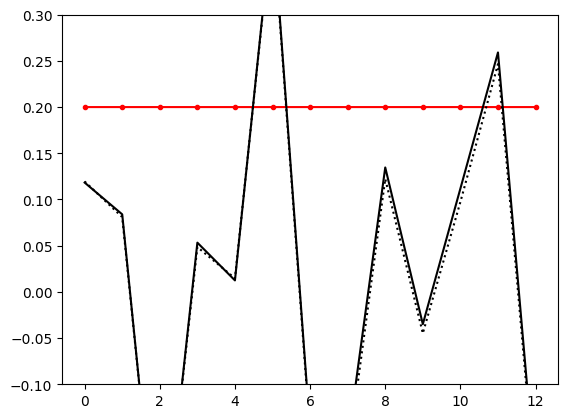

step: 43 0.34137248538087056
[[-5.7153491e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00 -4.1259118e-05  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.3823499e-06  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.2736333e-06
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -2.6693650e-07  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00

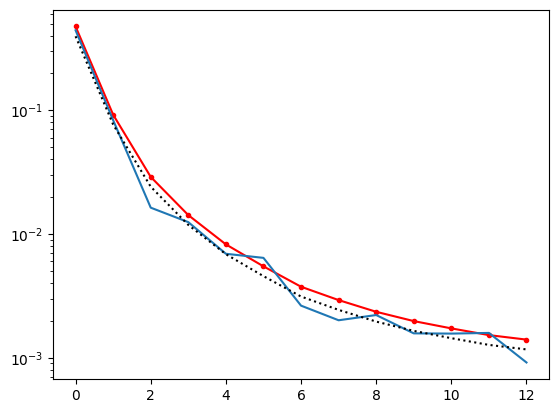

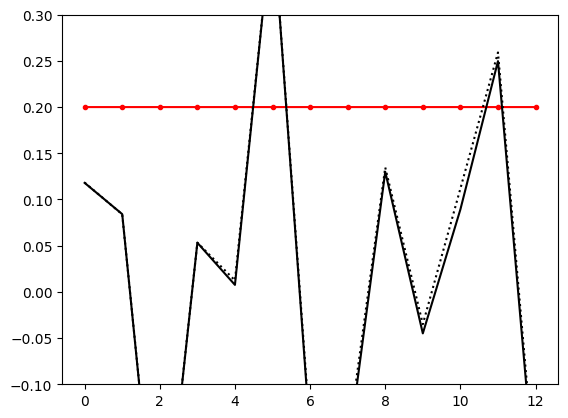

step: 46 0.324303861111827
[[-5.6291459e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00 -4.0206149e-05  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.3744943e-06  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.2827273e-06
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -2.6780396e-07  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  

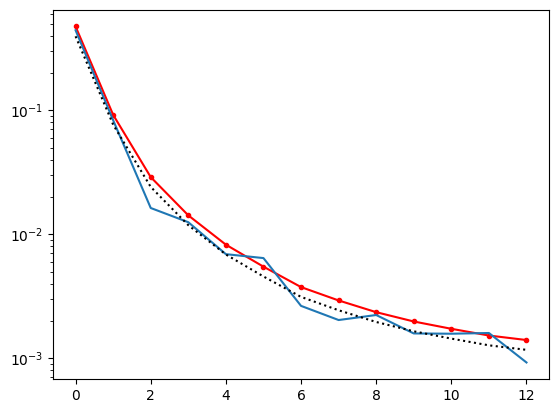

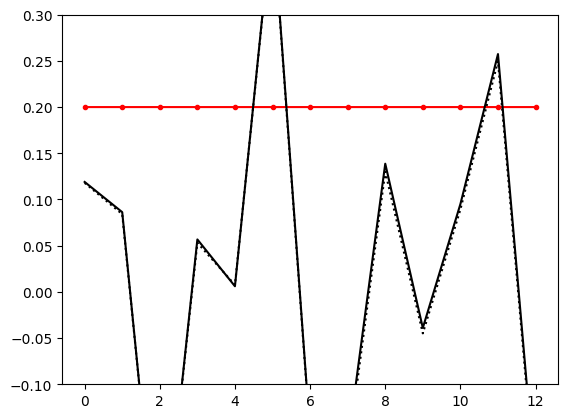

step: 49 0.30808866805623564
[[-5.6795642e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00 -4.0861218e-05  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.3780204e-06  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.2646279e-06
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -2.7121959e-07  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00

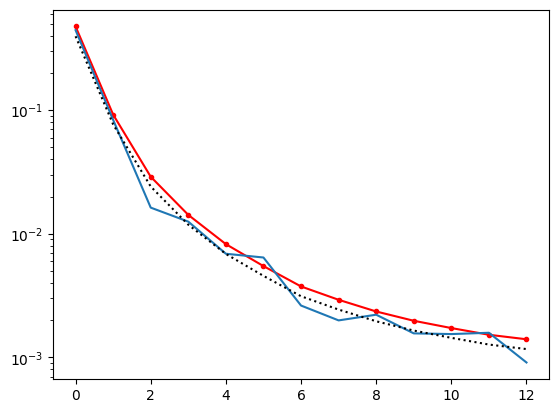

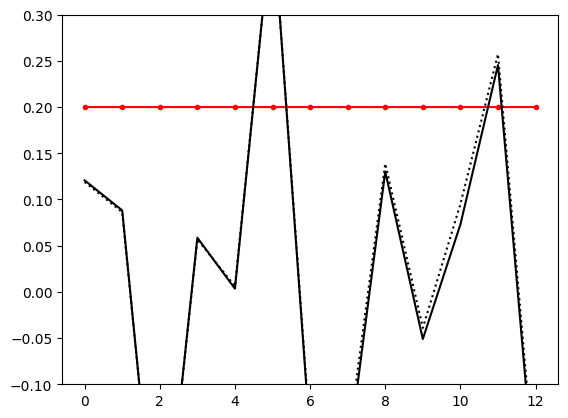

step: 52 0.29268423465342386
[[-6.16181758e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -4.11787805e-05  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.40547547e-06  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.28051659e-06
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.70920822e-07  0.00000000e+00  0.

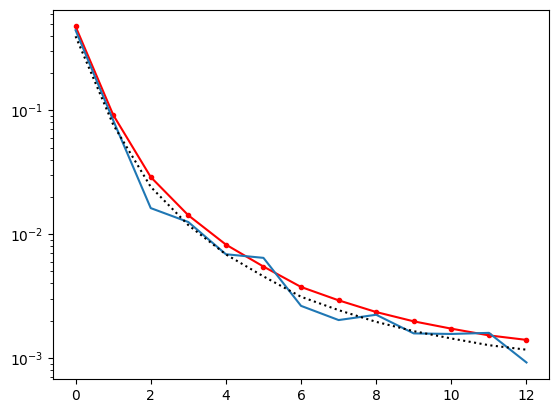

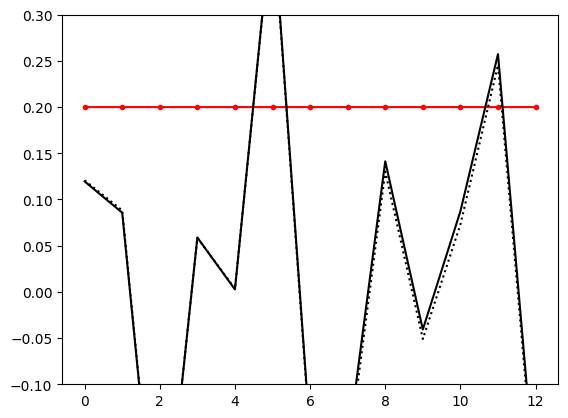

step: 55 0.27805002292075265
[[-5.74407575e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -4.06071849e-05  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.37776158e-06  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.26687576e-06
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.70121546e-07  0.00000000e+00  0.

KeyboardInterrupt: 

In [23]:
from datetime import datetime, timedelta
from jax.scipy.optimize import minimize

from multiprocessing.pool import ThreadPool as Pool 
pool = Pool() #jax pmap? check re-compilation times?
pmap = pool.map

#method = 'L-BFGS-B'
method = "l-bfgs-experimental-do-not-rely-on-this"
θ_rtol = 1e-5
z_rtol = 1e-5

θ_tol = 1e-5
z_tol = 1e-6

history = []
α=0.7
beta = 0.25

θ̃ = start_point
θ = start_point# if result.θ is not None else θ_start)
θL = start_point
Nθ = len(ravel_θ(θ̃))
time = timedelta(0)
for i in range(1, maxsteps+1):
        print("step:",i,α)
        t0 = datetime.now()

        if i > 1:
            xs = [x_data] + [prob.sample_x_z(_rng, θ)[0] for _rng in _split_rng(rng,nsims)]
            θ_tol = np.sqrt(-np.diag(H̃_inv_post)) * θ_rtol

        if i > 2:
            Δθ̃ = ravel_θ(history[-1]["θ̃"])- ravel_θ(history[-2]["θ̃"])
          #  if np.sqrt(-np.inner(Δθ̃, np.inner(np.linalg.pinv(history[-1]["H̃_inv_post"]), Δθ̃))) < θ_rtol:
           #     break

        # MUSE gradient
        def get_MAPs(x_z):
            x, ẑ_prev = x_z
            result = prob.z_MAP_and_score(x, ẑ_prev, θ, method=method, z_tol=z_tol, θ_tol=θ_tol)
            
            return result

        MAPs = list(pmap(get_MAPs, zip(xs, ẑs)))

        ẑs = [MAP.z for MAP in MAPs]
   #     if save_MAP_history:
    #        MAP_history_dat, *MAP_history_sims = [MAP.history for MAP in MAPs]
        s_MAP_dat, *s_MAP_sims = [MAP.s for MAP in MAPs]
        s̃_MAP_dat, *s̃_MAP_sims = [MAP.s̃ for MAP in MAPs]
        s̃_MUSE = unravel_θ(ravel_θ(s̃_MAP_dat) - np.nanmean(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0))
        s̃_prior, H̃_prior = gradθ_hessθ_logPrior(θ̃, transformed_θ=True)
        s̃_post = unravel_θ(ravel_θ(s̃_MUSE) + ravel_θ(s̃_prior))

        # print(s̃_MAP_sims)
        # H̃_inv_like_sims = np.diag(-1 / np.nanvar(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0))
        epsilon = 1e-8  # A small value to avoid division by zero
        variance = np.nanvar(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0)
        variance += epsilon  # Add epsilon to the variance to prevent zero values
        H̃_inv_like_sims = np.diag(-1 / variance)
        print(H̃_inv_like_sims)
        
       # try:
        # H̃_inv_post = np.linalg.pinv(np.linalg.pinv(H̃_inv_like_sims) + ravel_θ(H̃_prior).reshape(Nθ,Nθ))
        H̃_inv_post = np.linalg.pinv(np.linalg.pinv(H̃_inv_like_sims) + ravel_θ(H̃_prior).reshape(Nθ,Nθ))
        #except:
        #    print("error on Hessian inversion calc, prior ignored and trying again...")
       # H̃_inv_post = H̃_inv_like_sims
        t = datetime.now() - t0
        time += t

        history.append({
            "t":t, "θ̃":θ̃, "θ":θ,
            "s_MAP_dat": s_MAP_dat, "s_MAP_sims": s_MAP_sims,
            "s̃_MAP_dat": s̃_MAP_dat, "s̃_MAP_sims": s̃_MAP_sims, 
            "s̃_MUSE": s̃_MUSE,
            "s̃_prior": s̃_prior, "s̃_post": s̃_post, 
            "H̃_inv_post": H̃_inv_post, "H̃_prior": H̃_prior, 
            "H̃_inv_like_sims": H̃_inv_like_sims,
            "θ_tol": θ_tol,
        #    "MAP_history_dat": MAP_history_dat, 
         #   "MAP_history_sims": MAP_history_sims,
        })
        θ̃update = np.clip((np.inner(H̃_inv_post, ravel_θ(s̃_post))),-jnp.abs(ravel_θ(θ̃)*beta),jnp.abs(ravel_θ(θ̃)*beta))
        θ̃ = unravel_θ((ravel_θ(θ̃) - α * θ̃update))
        θ = θ̃
        print(((θ-tf_cut_flat)/tf_cut_flat))
        #print(θ)
        if i%3==0:
            plt.semilogy(start_point,"r.-")
            plt.plot(θ)
            plt.plot(tf_cut_flat,"k:")
            plt.show()
            
            
            plt.plot((start_point-tf_cut_flat)/tf_cut_flat,"r.-")
            plt.plot((θ-tf_cut_flat)/tf_cut_flat,"k")
            plt.plot((θL-tf_cut_flat)/tf_cut_flat,"k:")
    
            plt.ylim([-.1,.3])
            plt.show()
            
            θL = θ
            #LR decay
            α *= 0.95

In [26]:
#as you can see, convergence properties are wonky, takes a bit of time to start moving... 
#Should converge if you have the patients to let it run a couple of hours


In [27]:
#Now lets try to calculate the covariance! :D

In [28]:
s_MAP_sims = history[-1]["s_MAP_sims"]
_, *z_MAP_sims = ẑs

In [29]:
def z_MAP_guess_from_truth(x, z, θ):
        return unravel_z(0 * ravel_z(z))
    
nsims = 4
    
def get_J(
        result = None,
        θ = None,
        θ_tol = None,
        z_tol = None,
        method = None,
        rng = None,
        nsims = 10, 
        pmap = map,
        progress = False, 
        skip_errors = False,
    ):

        nsims_remaining = nsims 

        if nsims_remaining > 0:
            print(nsims_remaining)
            t0 = datetime.now()

            def get_s_MAP(rng):
                    (x, z) = prob.sample_x_z(rng, θ)
                    # if np.isnan(x).any() or np.isnan(z).any():
                    #     print("NaN detected in sampled (x, z)")
                    #     return None                    
                    z_MAP_guess = prob.z_MAP_guess_from_truth(x, z, θ)
                    # if np.isnan(z_MAP_guess).any():
                    #     print("NaN detected in z_MAP_guess!")
                    #     return None

                    #     result = prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol)
                    #     if np.isnan(result.s).any():
                    #         print("NaN detected in s_MAP!")
                    #         return None
                    return prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol).s
                

            rngs = _split_rng(rng, nsims_remaining)
            s_MAP_sims.extend(s for s in pmap(get_s_MAP, rngs) if s is not None)

#            time += datetime.now() - t0

        stacked_s = np.stack(list(map(ravel_θ, s_MAP_sims)))
        print("Stacked s_MAP_sims shape:", stacked_s.shape)
        print("Stacked s_MAP_sims values:", stacked_s)
        
        if np.isnan(stacked_s).any():
            print("NaN detected in stacked_s before computing J!")
            exit()
        J = np.atleast_2d(np.cov(np.stack(list(map(ravel_θ, s_MAP_sims))), rowvar=False))
        return J



In [30]:
J = get_J(rng=rng,θ =θ,method=method, θ_tol=θ_tol, z_tol=z_tol)

10
Stacked s_MAP_sims shape: (20, 20)
Stacked s_MAP_sims values: [[ 4.77598839e+01  8.31944702e+02  5.43342725e+03  2.04059375e+04
   5.40949609e+04  1.14084297e+05  2.05541000e+05  3.33253250e+05
   4.90638250e+05  6.72081750e+05  8.83605750e+05  1.09760325e+06
   1.32958400e+06  1.34422825e+06  1.20881950e+06  1.02253862e+06
   7.87393375e+05  5.02024688e+05  2.47267797e+05  1.07144906e+05]
 [ 4.64409370e+01  8.35785583e+02  5.46753711e+03  1.99682773e+04
   5.36771094e+04  1.15664797e+05  2.04490891e+05  3.33240500e+05
   4.91818781e+05  6.75405375e+05  8.80083000e+05  1.09790488e+06
   1.32516225e+06  1.33797650e+06  1.21291788e+06  1.02274750e+06
   7.89280625e+05  5.06600094e+05  2.44085500e+05  1.05710594e+05]
 [ 5.04822617e+01  8.22362366e+02  5.39839307e+03  1.97311035e+04
   5.44554648e+04  1.15273266e+05  2.07523188e+05  3.31197062e+05
   4.90696219e+05  6.74900250e+05  8.81786938e+05  1.09901900e+06
   1.32783812e+06  1.34389662e+06  1.21066062e+06  1.01746444e+06
   7.8454

In [31]:
J

array([[ 4.42479635e+06,  4.43282834e+06,  1.05716628e+07,
         2.47076977e+07,  2.04975217e+08,  2.87199168e+08,
         4.85738877e+08,  6.88177967e+08,  6.98058535e+08,
         5.52684323e+08,  3.10048265e+08,  6.26907545e+07,
        -2.48723255e+08, -4.25630901e+08, -3.38679184e+08,
        -1.93442573e+08, -7.41424148e+07, -8.10066485e+06,
         1.70815001e+07,  1.40546202e+07],
       [ 4.43282834e+06,  1.92863303e+07,  3.26964786e+07,
         4.24996416e+07,  2.06824316e+08,  3.32574103e+08,
         5.97639344e+08,  9.17224418e+08,  9.91555976e+08,
         9.21938607e+08,  8.05259367e+08,  5.95381053e+08,
         2.14789834e+08, -1.98753559e+08, -3.36372988e+08,
        -2.57903412e+08, -1.03681947e+08,  4.07318027e+06,
         4.18144768e+07,  3.46901792e+07],
       [ 1.05716628e+07,  3.26964786e+07,  2.22888755e+08,
         4.04777641e+08,  9.52408517e+08,  1.58048019e+09,
         2.51842618e+09,  3.53456155e+09,  3.39737069e+09,
         2.24774193e+09,  8.1

In [32]:
Hs = []

In [33]:
def pjacobian(f, x, step, pmap=map, pbar=None):
    print(step,x)
    step = step + np.array(0 * x) # make array if scalar

    def column(i):
    
        def v(ε):
            ε_vec = np.array(0 * x)
            ε_vec[i] = ε
            v = f(x + ε_vec)
            if pbar: pbar.update()
            return v

        return (v(step[i]) - v(-step[i])) / (2 * step[i])

    return np.array(list(pmap(column, range(len(x)))))

In [34]:
#This takes a while, roughly an hour or two... Can probably parallelize it across GPUs if you want.

from tqdm import tqdm
from jax.scipy.sparse.linalg import cg

step = None
skip_errors = False
def _get_H_i_old(rng, z_MAP_guess_fid, *, θ, method=None, θ_tol=None, z_tol=None, step=None, skip_errors=False):
    
    # for each sim, do one fit at fiducial which we'll
    # reuse as a starting point when fudging θ by +/-ϵ
    θfid = θ
    (x, z) = prob.sample_x_z(rng, θfid)
    if z_MAP_guess_fid is None:
        z_MAP_guess = _MAP_guess_from_truth(x, z, θfid)
        z_MAP_guess_fid = z_MAP_and_score(x, z_MAP_guess, θfid, method=method, θ_tol=θ_tol, z_tol=z_tol).z

    def get_s_MAP(θvec):
        θ = unravel_θ(θvec)
        (x, _) = prob.sample_x_z(copy(rng), θ)
        return ravel_θ(prob.z_MAP_and_score(x, z_MAP_guess_fid, θfid, method=method, θ_tol=θ_tol, z_tol=z_tol).s)

    return pjacobian(get_s_MAP, ravel_θ(θfid), step)


def _get_H_i(rng, z_MAP, *, θ, implicit_diff_cgtol=1e-3, method=None, θ_tol=None, z_tol=None, step=None, skip_errors=False):

        #implicit implementation..
        cg_kwargs = dict(tol=implicit_diff_cgtol)

        (x, z) = prob.sample_x_z(rng, θ)
        if z_MAP is None:
            z_MAP_guess = z_MAP_guess_from_truth(x, z, θ)
            z_MAP = prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol).z

        θ_vec, z_MAP_vec = ravel_θ(θ), ravel_z(z_MAP)
        #unravel_θ, unravel_z = unravel_θ, unravel_z

        # non-implicit-diff term
        H1 = jacfwd(
            lambda θ1: grad(
                lambda θ2: prob.logLike(prob.sample_x_z(rng, unravel_θ(θ1))[0], z_MAP, unravel_θ(θ2))
            )(θ_vec)
        )(θ_vec)

        # term involving dzMAP/dθ via implicit-diff (w/ conjugate-gradient linear solve)
        dFdθ = jacfwd(
            lambda θ: grad(
                lambda z: prob.logLike(x, unravel_z(z), unravel_θ(θ))
            )(z_MAP_vec)
        )(θ_vec)
        dFdθ1 = jacfwd(
            lambda θ1: grad(
                lambda z: prob.logLike(prob.sample_x_z(rng, unravel_θ(θ1))[0], unravel_z(z), θ)
            )(z_MAP_vec)
        )(θ_vec)
        inv_dFdz_dFdθ1 = vmap(
            lambda vec: cg(
                lambda vec: jvp(lambda z: grad(lambda z: prob.logLike(x, unravel_z(z), θ))(z), (z_MAP_vec,), (vec,))[1], 
                vec, 
                **cg_kwargs
            )[0], 
            in_axes=1, out_axes=1
        )(dFdθ1)
        H2 = -dFdθ.T @ inv_dFdz_dFdθ1
        return H1 + H2

Hs = []

nsims_remaining = nsims  #- len(result.Hs)

z_MAP_sims = z_MAP_sims[:4]

if nsims_remaining > 0:

    # default to finite difference step size of 0.1σ with σ roughly
    # estimated from s_MAP_sims sims, if we have them
    if step is None:
        if len(s_MAP_sims) > 0:
            step = 0.1 / np.std(np.stack(list(map(ravel_θ, s_MAP_sims))), axis=0)
        else:
            step = 1e-5
    
    Nθ = len(ravel_θ(θ))
    pbar = partial(tqdm, total=nsims_remaining, desc="get_H", disable=(True))

    t0 = datetime.now()
    rngs = _split_rng(rng, nsims)[-nsims_remaining:]
    z_MAP_sims = (z_MAP_sims + [None]*(max(0, nsims - len(z_MAP_sims))))[-nsims_remaining:]
    _get_H_ii = partial(_get_H_i, θ=θ, method=method, θ_tol=θ_tol, z_tol=z_tol, step=step, skip_errors=skip_errors)
    Hs.extend(H for H in pbar(map(lambda args: _get_H_ii(*args), zip(rngs, z_MAP_sims)) )if H is not None)
   # result.time += datetime.now() - t0

avg = np.mean#np.median if use_median else np.mean
H = avg(np.array(Hs), axis=0)

In [35]:
Hs[0]

Array([[ 1.99414062e+00,  2.37109375e+00, -8.47839355e-01,
        -6.11022949e-01, -3.00012207e+00, -1.96032715e+00,
         4.76086426e+00,  2.15408325e+00, -4.75494385e+00,
         5.57260132e+00, -5.57128906e-01,  1.68493652e+00,
        -2.58618164e+00, -7.03857422e-01, -2.02813721e+00,
        -1.87963867e+00, -2.19421387e-01,  5.57769775e-01,
        -2.63658524e-01, -1.94496155e-01],
       [ 3.43359375e+00,  1.17656250e+02,  1.09843750e+02,
        -5.14941406e+00,  6.87719727e+00,  1.12006836e+01,
        -1.23046875e+00,  1.04804688e+01,  2.75976562e+00,
         1.02099609e+00,  5.03076172e+00,  3.11279297e+00,
        -1.62070312e+01, -4.06933594e+00,  9.54760742e+00,
        -9.22106934e+00,  1.28381348e+00, -1.59777832e+00,
        -1.78187561e+00, -6.01501465e-02],
       [ 5.62622070e-01,  1.19140625e+02,  1.96350000e+03,
         1.37925000e+03,  7.54648438e+01,  6.04990234e+01,
         4.51914062e+01,  4.02739258e+01,  7.33750000e+01,
         4.29843750e+01,  6.6

In [36]:
import scipy as sp

Nθ = len(ravel(θ))

H_prior = -ravel(prob.gradθ_hessθ_logPrior(θ, transformed_θ=False)[1]).reshape(Nθ,Nθ)
Σ_inv = H.T @ np.linalg.pinv(J) @ H + H_prior
Σ = np.linalg.pinv(Σ_inv)

try:
    if θ is not None:
        if Nθ == 1:
            dist = sp.stats.norm(ravel(θ), np.sqrt(Σ[0,0]))
        else:
            dist = sp.stats.multivariate_normal(ravel(θ), Σ)
except:
    print("likely error in covariance... proceed with caution!")

likely error in covariance... proceed with caution!


In [37]:
cond_number = np.linalg.cond(J)
print(f"Condition number of J: {cond_number}")
if cond_number > 1e12:
    print("Warning: J is nearly singular!")

Condition number of J: 2.8137953493295354e+17


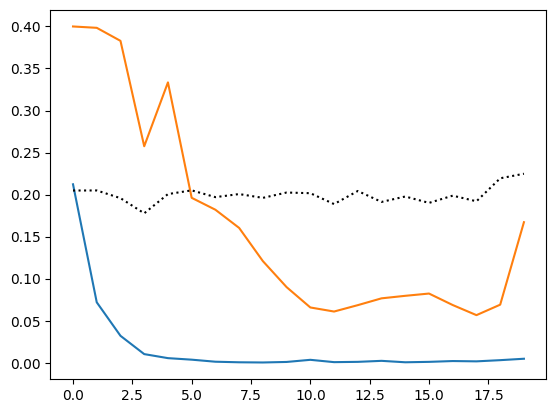

In [38]:
plt.plot(1/np.sqrt(np.diag(Σ_inv))/tf_cut_flat)
plt.plot(np.sqrt(np.diag(Σ))/tf_cut_flat)

plt.plot(abs((start_point-θ)/tf_cut_flat),"k:")

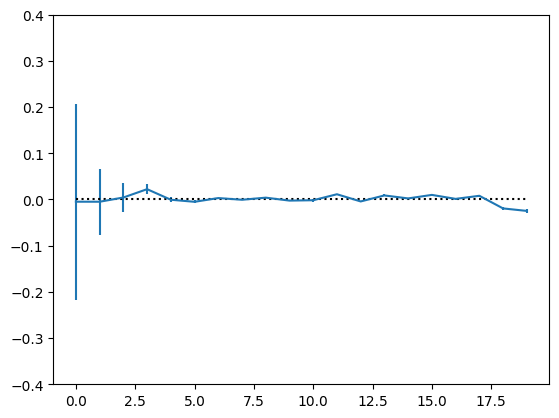

In [39]:
#need to run optimization for longer, since thsoe smaller scale modes in each mu-bin are not converged...
plt.errorbar(np.arange(len(tf_cut_flat)),(θ-tf_cut_flat)/tf_cut_flat,yerr=np.abs(1/np.sqrt(np.diag(Σ_inv))/tf_cut_flat))
plt.plot(np.arange(len(tf_cut_flat)),np.arange(len(tf_cut_flat))*0.0,"k:")
plt.ylim(-0.4,0.4)
plt.show()

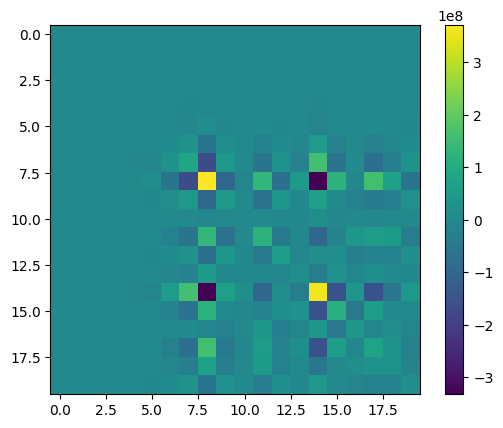

In [40]:
imshow(Σ_inv)
colorbar()